In [1]:
import torch

torch.cuda.is_available()

True

In [2]:
import pandas as pd
import zipfile
import urllib.request
import time
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Optimizer
from sklearn.model_selection import KFold

from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange


In [3]:
import os

# get args from main_gnn CLI
class Argument(object):
    name = "args"
    
args = Argument()
args.batch_size = 256
args.num_workers = 0
args.num_layers = 5
args.emb_dim = 600
args.drop_ratio = 0
args.graph_pooling = "sum"
args.checkpoint_dir = "checkpoint"
args.device = 0

## bbp

ref: https://github.com/georgelamb19/chempropBayes/blob/master/chemprop/bayes/bbp.py


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.autograd import Variable

In [5]:
import matplotlib.pyplot as plt
import GPy

## single-layer BayesLinear

In [6]:
def KLD_cost(mu_p, sig_p, mu_q, sig_q):
    KLD = 0.5 * (2 * torch.log(sig_p / sig_q) - 1 + (sig_q / sig_p).pow(2) + ((mu_p - mu_q) / sig_p).pow(2)).sum()
    # https://arxiv.org/abs/1312.6114 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    #print(2 * torch.log(sig_p / sig_q).sum())
    #print(((sig_q / sig_p).pow(2)).sum())
    #print((((mu_p - mu_q) / sig_p).pow(2)).sum())
    return KLD


class BayesLinear(nn.Module):
    
    """
    Linear Layer where activations are sampled from a fully factorised normal which is given by aggregating
    the moments of each weight's normal distribution. The KL divergence is obtained in closed form. Only works
    with gaussian priors.
    """
    
    def __init__(self, n_in, n_out, prior_sig, bias = True):
        
        super(BayesLinear, self).__init__()
        
        self.n_in = n_in
        self.n_out = n_out
        self.bias = bias
        self.prior_sig = prior_sig
        
        # initialise mu for weights
        self.W_mu = nn.Parameter(torch.Tensor(self.n_in, self.n_out).uniform_(-0.02, 0.02))
        
        # initialise mu for biases
        if self.bias:
            self.b_mu = nn.Parameter(torch.Tensor(self.n_out).uniform_(-0.02, 0.02))

            
    def init_rho(self, p_min, p_max):
        self.W_p = nn.Parameter(torch.Tensor(self.n_in, self.n_out).uniform_(p_min, p_max))
        if self.bias:
            self.b_p = nn.Parameter(torch.Tensor(self.n_out).uniform_(p_min, p_max))     


    def forward(self, X, sample=False):
        
        if sample:

            ### weights
            
            std_w = 1e-6 + F.softplus(self.W_p, beta=1, threshold=20) # compute stds for weights
            act_W_mu = torch.mm(X, self.W_mu)  # activation means
            act_W_std = torch.sqrt(torch.clamp_min(torch.mm(X.pow(2), std_w.pow(2)),1e-6)) # actiavtion stds
            
            eps_W = Variable(self.W_mu.data.new(act_W_std.size()).normal_(mean=0, std=1)) # draw samples from 0,1 gaussian
            act_W_out = act_W_mu + act_W_std * eps_W # sample weights from 'posterior'
            
            output = act_W_out
            kld = KLD_cost(mu_p=0, sig_p=self.prior_sig, mu_q=self.W_mu, sig_q=std_w)
            
            if self.bias:
                
                std_b = 1e-6 + F.softplus(self.b_p, beta=1, threshold=20) # compute stds for biases
                eps_b = Variable(self.b_mu.data.new(std_b.size()).normal_(mean=0, std=1)) # draw samples from 0,1 gaussian
                act_b_out = self.b_mu + std_b * eps_b # sample biases from 'posterior'
                output += act_b_out.unsqueeze(0).expand(X.shape[0], -1)
                kld += KLD_cost(mu_p=0, sig_p=self.prior_sig, mu_q=self.b_mu, sig_q=std_b)
       
            return output, kld
        
        
        else:
            
            output = torch.mm(X, self.W_mu)
            
            # kld is just standard regularisation term
            kld = (0.5*((self.W_mu / self.prior_sig).pow(2))+torch.log(self.prior_sig*torch.sqrt(torch.tensor(2*np.pi)))).sum()
            
            if self.bias:
                output += self.b_mu.expand(X.size()[0], self.n_out)
                
                kld += (0.5*((self.b_mu / self.prior_sig).pow(2))+torch.log(self.prior_sig*torch.sqrt(torch.tensor(2*np.pi)))).sum()
            
            
            return output, kld

In [7]:
def neg_log_like(output, target, sigma):
    """
    Negative gaussian log likelihood (scaled, per example)
    """
    
    exponent = -0.5*torch.sum(
        (target - output)**2/sigma**2
        , 1)

    log_coeff = -torch.sum(torch.log(sigma)) - len(sigma) * torch.log(torch.sqrt(torch.tensor(2*np.pi)))
    
    scale = 1 / len(exponent)
    
    return - scale * (log_coeff + exponent).sum()

In [8]:
np.random.seed(2)

no_points = 400
lengthscale = 1
variance = 1.0
sig_noise = 0.3

x1 = np.random.uniform(-3, 3, no_points)[:, None]
x1.sort(axis = 0)
x2 = np.random.uniform(6, 9, no_points)[:, None]
x2.sort(axis = 0)

x = np.append(x1, x2, axis=0)

x.shape

(800, 1)

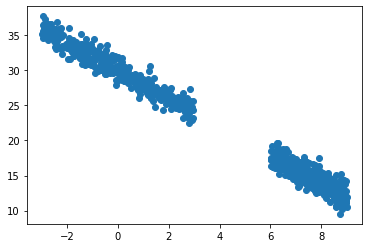

In [9]:
""" DATA 1 """
# # GP is simply used to produce covariance
# x = np.random.uniform(-3, 3, no_points)[:, None]

# k = GPy.kern.RBF(input_dim=1, variance=variance, lengthscale=lengthscale)
# C = k.K(x, x) + np.eye(no_points) * (x + 2)**2 * sig_noise**2

# k, C.shape

# # covariance matrix from RBF kernel
# y = np.random.multivariate_normal(np.zeros((no_points)), C)[:, None] + 10
# # y = (y - y.mean())

# y.shape


""" DATA 2 """

y = x * -2 + np.random.normal(size=x.shape) + 30

plt.scatter(x, y)

((250, 1), (250, 1))

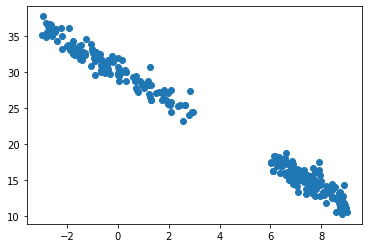

In [10]:
# normalise train data
randomIndices = np.random.choice(range(x.shape[0]), 250, replace=False)

x_train = x[randomIndices]
y_train = y[randomIndices]

plt.scatter(x_train, y_train)

x_train.shape, y_train.shape

In [11]:
""" define model """
model = BayesLinear(n_in=1, n_out=1, prior_sig=1, bias = True)
# extra addition
# model.init_rho(-0.02, 0.02)
model.init_rho(-5.5, 1)

# define optimiser
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)

# train
train_data_size = x_train.shape[0]
log_noise = nn.Parameter(torch.ones(1))

for i in range(1000):
    optimizer.zero_grad()

    # get out and loss
    out, kld = model.forward(torch.Tensor(x_train), sample=False)
    
    # total loss = prediction error + kld
    kl_loss = kld / train_data_size
    loss = neg_log_like(out, torch.Tensor(y_train), torch.exp(log_noise)) + kl_loss 

    loss.backward()
    optimizer.step()
    
    if i % 100 ==0:
        print(loss)

tensor(42.5040, grad_fn=<AddBackward0>)
tensor(19.7235, grad_fn=<AddBackward0>)
tensor(10.0472, grad_fn=<AddBackward0>)
tensor(5.7912, grad_fn=<AddBackward0>)
tensor(4.2726, grad_fn=<AddBackward0>)
tensor(3.8408, grad_fn=<AddBackward0>)
tensor(3.7438, grad_fn=<AddBackward0>)
tensor(3.7267, grad_fn=<AddBackward0>)
tensor(3.7243, grad_fn=<AddBackward0>)
tensor(3.7240, grad_fn=<AddBackward0>)


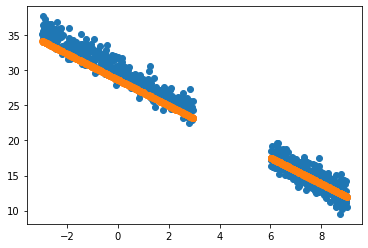

In [12]:
"""without sample uncertainty """
out, kld = model(torch.Tensor(x), sample=False)

plt.scatter(x, y)
plt.scatter(x.flatten(), out.cpu().detach().numpy().flatten())

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1886.73it/s]


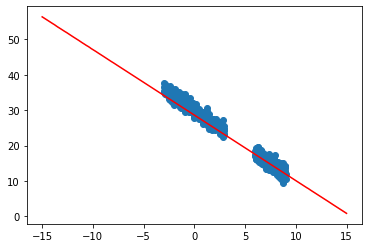

In [13]:
""" with sample uncertainty """

# get epistemic uncertainty by sampling many times
xsample = torch.linspace(-15, 15, 200).view(-1, 1)

samples, noises = [], []
for i in tqdm(range(100)):

    # network return preds and loss. Preds are made of mean and var 
    preds, _ = model(xsample, sample=True)

    # append samples and noise
    pred_mean = preds[:, 0].cpu().data.numpy() 
    samples.append(pred_mean)

samples = np.array(samples)
means = samples.mean(axis=0)

# get noises (No aleatoric since model outputs single number)
# aleatoric is obtained from network output. Average noise across 100 runs
epistemic = samples.var(axis=0)**0.5
# cap uncertainty that's too high
epistemic = np.minimum(epistemic, 10e3)

# total uncertainty
total_unc = epistemic

# plt.plot(xsample, epistemic)

# plot original data
plt.scatter(x, y)

# plot means of prediction
plt.plot(xsample, means, "r")

# # plot noise
plt.fill_between(xsample[:, 0], means - total_unc, means + total_unc, alpha = 0.4)


## multi-layer BayesLinear

In [14]:
class ModelBBP(nn.Module):
    def __init__(self):
        super(ModelBBP, self).__init__()
        self.prior_sig = torch.Tensor(0)
        
        hidden_dim = 100
        
        self.l1 = BayesLinear(n_in=1, n_out=hidden_dim, prior_sig=1, bias = True)
        self.l1.init_rho(-5.5, -1)
        self.l2a = BayesLinear(n_in=hidden_dim, n_out=hidden_dim, prior_sig=1, bias = True)
        self.l2a.init_rho(-5.5, -1)
        self.l2b = BayesLinear(n_in=hidden_dim, n_out=hidden_dim, prior_sig=1, bias = True)
        self.l2b.init_rho(-5.5, -1)
        self.l3 = BayesLinear(n_in=hidden_dim, n_out=1, prior_sig=1, bias = True)
        self.l3.init_rho(-5.5, -1)
        self.activation = nn.ReLU(inplace=True)
        
    def forward(self, X, sample=False):
        
        X, tkl = self.l1(X, sample)
        X = self.activation(X)

        X, kl = self.l2a(X, sample)
        X = self.activation(X)
        tkl += kl

        X, kl = self.l2b(X, sample)
        X = self.activation(X)
        tkl += kl
        
        X, kl = self.l3(X, sample)
#         X = self.activation(X)
        tkl += kl
        
        return X, tkl

In [15]:
np.random.seed(2)

no_points = 400
lengthscale = 1
variance = 1.0
sig_noise = 0.3

x1 = np.random.uniform(-3, 3, no_points)[:, None]
x1.sort(axis = 0)
x2 = np.random.uniform(6, 9, no_points)[:, None]
x2.sort(axis = 0)

x = np.append(x1, x2, axis=0)

x.shape

(800, 1)

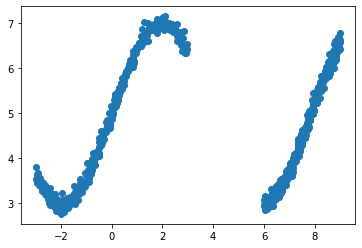

In [16]:
""" DATA 1 """
# # GP is simply used to produce covariance
# x = np.random.uniform(-3, 3, no_points)[:, None]

# k = GPy.kern.RBF(input_dim=1, variance=variance, lengthscale=lengthscale)
# C = k.K(x, x) + np.eye(no_points) * (x + 2)**2 * sig_noise**2

# k, C.shape

# # covariance matrix from RBF kernel
# y = np.random.multivariate_normal(np.zeros((no_points)), C)[:, None] + 10
# # y = (y - y.mean())

# y.shape


""" DATA 2 """

# y = x * -2 + np.random.normal(size=x.shape) + 30


""" DATA 3 """
# y = 50*np.sin(0.8*x) + 100 + 10*np.random.normal(size=x.shape)
y = 2*np.sin(0.8*x) + 5 + 0.1*np.random.normal(size=x.shape)

plt.scatter(x, y)

((250, 1), (250, 1))

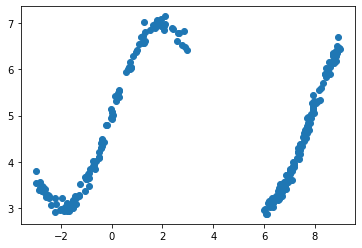

In [17]:
# normalise train data
randomIndices = np.random.choice(range(x.shape[0]), 250, replace=False)

x_train = x[randomIndices]
y_train = y[randomIndices]

plt.scatter(x_train, y_train)

x_train.shape, y_train.shape

In [23]:
""" define model """
model = ModelBBP()

# define optimiser
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)

# train
train_data_size = x_train.shape[0]
log_noise = nn.Parameter(torch.ones(1)*0.001)

for i in range(1000):
    optimizer.zero_grad()

    # get out and loss
    out, kld = model.forward(torch.Tensor(x_train), sample=False)
    
    # total loss = prediction error + kld
    kl_loss = kld / train_data_size
    loss = neg_log_like(out, torch.Tensor(y_train), torch.exp(log_noise)) + kl_loss 

    loss.backward()
    optimizer.step()
    
    if i % 100 ==0:
        print(loss)

tensor(87.8269, grad_fn=<AddBackward0>)
tensor(78.2027, grad_fn=<AddBackward0>)
tensor(77.1428, grad_fn=<AddBackward0>)
tensor(76.8040, grad_fn=<AddBackward0>)
tensor(76.9403, grad_fn=<AddBackward0>)
tensor(76.5281, grad_fn=<AddBackward0>)
tensor(76.4554, grad_fn=<AddBackward0>)
tensor(76.4205, grad_fn=<AddBackward0>)
tensor(76.3901, grad_fn=<AddBackward0>)
tensor(76.3704, grad_fn=<AddBackward0>)


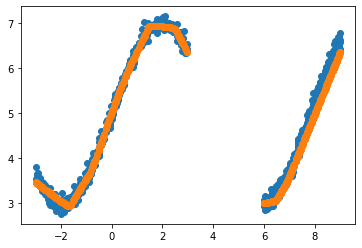

In [24]:
"""without sample uncertainty """
out, kld = model(torch.Tensor(x), sample=False)

plt.scatter(x, y)
plt.scatter(x.flatten(), out.cpu().detach().numpy().flatten())

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 226.24it/s]


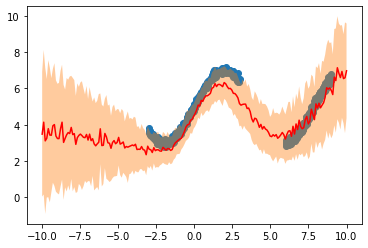

In [25]:
""" with sample uncertainty """

# get epistemic uncertainty by sampling mFany times
xsample = torch.linspace(-10, 10, 200).view(-1, 1)
# xsample = torch.Tensor(x) 

samples, noises = [], []
for i in tqdm(range(100)):

    # network return preds and loss. Preds are made of mean and var 
    preds, _ = model(xsample, sample=True)

    # append samples and noise
    pred_mean = preds[:, 0].cpu().data.numpy() 
    samples.append(pred_mean)

samples = np.array(samples)
means = samples.mean(axis=0)

# get noises (No aleatoric since model outputs single number)
# aleatoric is obtained from network output. Average noise across 100 runs
epistemic = samples.var(axis=0)**0.5
# cap uncertainty that's too high
epistemic = np.minimum(epistemic, 1e5)

# total uncertainty
total_unc = epistemic

# plt.plot(xsample, epistemic)

# plot original data
plt.scatter(x, y)

# plot means of prediction
plt.plot(xsample, means, "r")

# # plot noise
plt.fill_between(xsample[:, 0], means - total_unc, means + total_unc, alpha = 0.4)


seems like the rho initiation is very important. If it's too big - becomes too uncertain (e.g -0.02 to 0.02). But (-5.5 to -1) seems ideal

## torch-bnn

In [84]:
import torchbnn as bnn
import torch
import torch.nn as nn
import torch.optim as optim

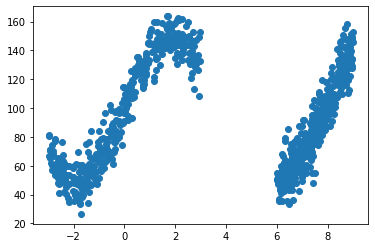

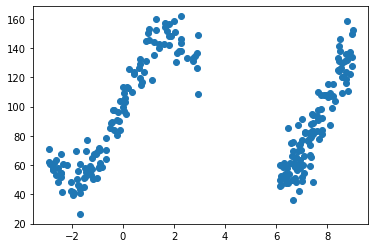

((250, 1), (250, 1))

In [127]:
""" DATA 1 """
# # GP is simply used to produce covariance
# x = np.random.uniform(-3, 3, no_points)[:, None]

# k = GPy.kern.RBF(input_dim=1, variance=variance, lengthscale=lengthscale)
# C = k.K(x, x) + np.eye(no_points) * (x + 2)**2 * sig_noise**2

# k, C.shape

# # covariance matrix from RBF kernel
# y = np.random.multivariate_normal(np.zeros((no_points)), C)[:, None] + 10
# # y = (y - y.mean())

# y.shape


""" DATA 2 """

# y = x * -2 + np.random.normal(size=x.shape) + 30


""" DATA 3 """
y = 50*np.sin(0.8*x) + 100 + 10*np.random.normal(size=x.shape)
# y = 2*np.sin(0.8*x) + 5 + 0.1*np.random.normal(size=x.shape)

plt.scatter(x, y)
plt.show()

# normalise train data
randomIndices = np.random.choice(range(x.shape[0]), 250, replace=False)

x_train = x[randomIndices]
y_train = y[randomIndices]

plt.scatter(x_train, y_train)
plt.show()

x_train.shape, y_train.shape

In [128]:
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1, out_features=100),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=100, out_features=100),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=100, out_features=100),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=100, out_features=1),
)

mse_loss = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

optimizer = optim.Adam(model.parameters(), lr=0.01)

In [129]:
for step in tqdm(range(3000)):
    # prediction
    pre = model(torch.Tensor(x_train))
    
    # loss
    mse = mse_loss(pre, torch.Tensor(y_train))
    kl = kl_loss(model)
    cost = mse + kl_weight*kl
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    if step % 100 == 0:
        print(cost)

  1%|▌                                                                              | 22/3000 [00:00<00:14, 210.58it/s]

tensor([9582.4385], grad_fn=<AddBackward0>)


  4%|███▍                                                                          | 132/3000 [00:00<00:13, 215.26it/s]

tensor([876.9670], grad_fn=<AddBackward0>)


  8%|██████▏                                                                       | 237/3000 [00:01<00:13, 199.61it/s]

tensor([372.3940], grad_fn=<AddBackward0>)


 11%|████████▊                                                                     | 339/3000 [00:01<00:13, 199.49it/s]

tensor([554.2575], grad_fn=<AddBackward0>)


 14%|██████████▉                                                                   | 419/3000 [00:02<00:13, 197.99it/s]

tensor([443.3065], grad_fn=<AddBackward0>)


 18%|██████████████                                                                | 539/3000 [00:02<00:12, 193.03it/s]

tensor([251.2219], grad_fn=<AddBackward0>)


 21%|████████████████                                                              | 620/3000 [00:03<00:12, 197.49it/s]

tensor([200.7816], grad_fn=<AddBackward0>)


 24%|██████████████████▋                                                           | 721/3000 [00:03<00:11, 194.40it/s]

tensor([500.9584], grad_fn=<AddBackward0>)


 27%|█████████████████████▎                                                        | 821/3000 [00:04<00:11, 194.36it/s]

tensor([204.4312], grad_fn=<AddBackward0>)


 31%|███████████████████████▉                                                      | 922/3000 [00:04<00:10, 195.07it/s]

tensor([393.8483], grad_fn=<AddBackward0>)


 34%|██████████████████████████▏                                                  | 1020/3000 [00:05<00:10, 183.47it/s]

tensor([146.6310], grad_fn=<AddBackward0>)


 37%|████████████████████████████▋                                                | 1117/3000 [00:05<00:09, 188.46it/s]

tensor([125.4728], grad_fn=<AddBackward0>)


 41%|███████████████████████████████▋                                             | 1237/3000 [00:06<00:09, 192.37it/s]

tensor([256.1136], grad_fn=<AddBackward0>)


 45%|██████████████████████████████████▎                                          | 1337/3000 [00:06<00:08, 191.77it/s]

tensor([280.7927], grad_fn=<AddBackward0>)


 48%|████████████████████████████████████▊                                        | 1435/3000 [00:07<00:08, 189.56it/s]

tensor([113.8807], grad_fn=<AddBackward0>)


 51%|███████████████████████████████████████▎                                     | 1530/3000 [00:07<00:08, 180.14it/s]

tensor([129.9402], grad_fn=<AddBackward0>)


 54%|█████████████████████████████████████████▋                                   | 1625/3000 [00:08<00:07, 178.06it/s]

tensor([119.3563], grad_fn=<AddBackward0>)


 57%|████████████████████████████████████████████▏                                | 1721/3000 [00:08<00:06, 184.73it/s]

tensor([143.9719], grad_fn=<AddBackward0>)


 61%|██████████████████████████████████████████████▌                              | 1816/3000 [00:09<00:06, 183.98it/s]

tensor([136.3292], grad_fn=<AddBackward0>)


 64%|█████████████████████████████████████████████████▌                           | 1930/3000 [00:10<00:05, 184.83it/s]

tensor([356.9639], grad_fn=<AddBackward0>)


 68%|███████████████████████████████████████████████████▉                         | 2025/3000 [00:10<00:05, 186.17it/s]

tensor([145.1271], grad_fn=<AddBackward0>)


 71%|██████████████████████████████████████████████████████▍                      | 2121/3000 [00:11<00:04, 182.74it/s]

tensor([171.0363], grad_fn=<AddBackward0>)


 74%|█████████████████████████████████████████████████████████▎                   | 2235/3000 [00:11<00:04, 181.49it/s]

tensor([103.0116], grad_fn=<AddBackward0>)


 78%|███████████████████████████████████████████████████████████▊                 | 2330/3000 [00:12<00:03, 184.42it/s]

tensor([120.2290], grad_fn=<AddBackward0>)


 81%|██████████████████████████████████████████████████████████████▏              | 2425/3000 [00:12<00:03, 183.82it/s]

tensor([176.5773], grad_fn=<AddBackward0>)


 84%|████████████████████████████████████████████████████████████████▋            | 2520/3000 [00:13<00:02, 184.41it/s]

tensor([146.3273], grad_fn=<AddBackward0>)


 88%|███████████████████████████████████████████████████████████████████▌         | 2634/3000 [00:13<00:01, 183.45it/s]

tensor([111.2883], grad_fn=<AddBackward0>)


 91%|██████████████████████████████████████████████████████████████████████       | 2729/3000 [00:14<00:01, 184.04it/s]

tensor([98.1722], grad_fn=<AddBackward0>)


 94%|████████████████████████████████████████████████████████████████████████▍    | 2824/3000 [00:14<00:00, 183.27it/s]

tensor([141.4040], grad_fn=<AddBackward0>)


 97%|██████████████████████████████████████████████████████████████████████████▉  | 2919/3000 [00:15<00:00, 182.89it/s]

tensor([153.0162], grad_fn=<AddBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:15<00:00, 188.59it/s]


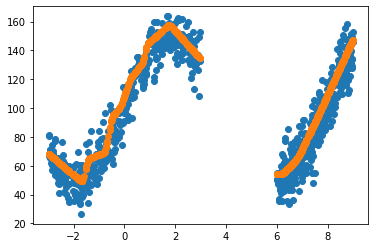

In [137]:
"""without sample uncertainty """
out = model(torch.Tensor(x))

plt.scatter(x, y)
plt.scatter(x.flatten(), out.cpu().detach().numpy().flatten())

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1190.54it/s]


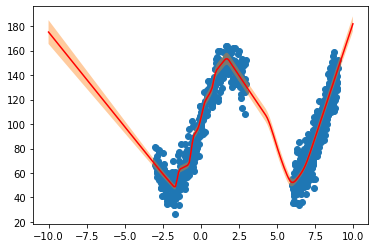

In [139]:
""" with sample uncertainty """

# get epistemic uncertainty by sampling mFany times
xsample = torch.linspace(-10, 10, 200).view(-1, 1)
# xsample = torch.Tensor(x) 

samples, noises = [], []
for i in tqdm(range(100)):

    # network return preds and loss. Preds are made of mean and var 
    preds = model(xsample)

    # append samples and noise
    pred_mean = preds[:, 0].cpu().data.numpy() 
    samples.append(pred_mean)

samples = np.array(samples)
means = samples.mean(axis=0)

# get noises (No aleatoric since model outputs single number)
# aleatoric is obtained from network output. Average noise across 100 runs
epistemic = samples.var(axis=0)**0.5
# cap uncertainty that's too high
epistemic = np.minimum(epistemic, 1e5)

# total uncertainty
total_unc = epistemic

# plt.plot(xsample, epistemic)

# plot original data
plt.scatter(x, y)

# plot means of prediction
plt.plot(xsample, means, "r")

# # plot noise
plt.fill_between(xsample[:, 0], means - total_unc, means + total_unc, alpha = 0.4)


## debug

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator

from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X, y = load_boston(return_X_y=True)
X = StandardScaler().fit_transform(X)
y = StandardScaler().fit_transform(np.expand_dims(y, -1))

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.25,
                                                    random_state=42)


X_train, y_train = torch.tensor(X_train).float(), torch.tensor(y_train).float()
X_test, y_test = torch.tensor(X_test).float(), torch.tensor(y_test).float()


@variational_estimator
class BayesianRegressor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        #self.linear = nn.Linear(input_dim, output_dim)
        self.blinear1 = BayesianLinear(input_dim, 512)
        self.blinear2 = BayesianLinear(512, output_dim)
        
    def forward(self, x):
        x_ = self.blinear1(x)
        x_ = F.relu(x_)
        return self.blinear2(x_)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
regressor = BayesianRegressor(13, 1).to(device)
optimizer = optim.Adam(regressor.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

ds_train = torch.utils.data.TensorDataset(X_train, y_train)
dataloader_train = torch.utils.data.DataLoader(ds_train, batch_size=16, shuffle=True)

ds_test = torch.utils.data.TensorDataset(X_test, y_test)
dataloader_test = torch.utils.data.DataLoader(ds_test, batch_size=16, shuffle=True)


iteration = 0
for epoch in range(5):
    for i, (datapoints, labels) in enumerate(dataloader_train):
        break
    break
#         optimizer.zero_grad()
        
#         loss = regressor.sample_elbo(inputs=datapoints.to(device),
#                            labels=labels.to(device),
#                            criterion=criterion,
#                            sample_nbr=3,
#                            complexity_cost_weight=1/X_train.shape[0])
#         loss.backward()
#         optimizer.step()
        
#         iteration += 1
# #         if iteration%100==0:
#         print("Loss: {:.4f}".format(loss))

In [52]:
datapoints.shape, labels.shape

(torch.Size([16, 13]), torch.Size([16, 1]))

In [53]:
datapoints

tensor([[-3.9939e-01, -4.8772e-01, -5.4815e-01, -2.7260e-01, -5.3294e-01,
          1.3016e-01, -5.0762e-01,  3.5432e-01, -5.2300e-01, -7.2006e-01,
          5.2916e-01,  4.4105e-01, -8.1063e-01],
        [-2.5899e-01, -4.8772e-01, -4.3726e-01, -2.7260e-01, -1.4422e-01,
         -4.7674e-01,  4.7740e-01,  9.2677e-02, -6.3796e-01, -6.0128e-01,
          1.1765e+00, -1.3604e+00,  2.1106e+00],
        [-4.1667e-01, -4.8772e-01, -8.6769e-01, -2.7260e-01, -3.4290e-01,
         -3.2145e-01, -1.1122e+00,  4.8353e-01, -5.2300e-01, -1.0942e+00,
          8.0658e-01,  4.3272e-01, -5.8075e-01],
        [-4.1697e-01,  1.8729e+00, -1.0734e+00, -2.7260e-01, -6.1069e-01,
          8.3964e-01, -1.4393e+00,  1.2694e+00, -5.2300e-01, -2.2710e-01,
         -3.9557e-01,  3.4314e-01, -1.1274e+00],
        [-1.1382e-01, -4.8772e-01, -1.8046e-01, -2.7260e-01, -9.2387e-02,
         -1.8686e+00, -1.0944e+00, -6.0640e-01, -6.3796e-01, -6.1909e-01,
         -2.5677e-02, -6.8243e-02, -1.8311e-03],
        [-4.158

In [54]:
labels

tensor([[ 0.0617],
        [-1.0158],
        [-0.2104],
        [ 0.9433],
        [-0.7001],
        [ 1.1719],
        [ 0.4209],
        [ 1.3678],
        [-0.7545],
        [-0.3627],
        [-0.0362],
        [-0.4498],
        [-1.6688],
        [ 0.2468],
        [-0.0580],
        [-1.2008]])